### Some tips
* `tensor.squeeze()`: delete dimensions with size 1, egg. `[1, 28, 28] -> [28, 28]`
* `tensor.flatten(start_dim=0)`: expend tensor to one dimension, egg. `[1, 28, 28] -> [784]`
* `transforms.ToTensor()`:  convert `(H x W x C)` of `[0, 255]` to a torch.FloatTensor `(C x H x W)` of `[0.0, 1.0]`
* `tensor.argmax(dim=1)`: return indices of the maximum values across a dimension
* `torch.sum(t_x == t_x)`: compute the number of elements in x equals to that in y
* `torch.cat(tensors, dim=0)`: concatenates tensor tuples
* `torch.stack(tensors, dim=0)`: concatenates tensor tuples along a new dimension
* `torch.unsqueeze(input, dim)`: insert a dimension of size one at the specified position to a tensor

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
import time
import math
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import torchvision.models as tvmodels
from torch.autograd import Variable

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

### Step 1: load datasets 

#### Load fake images

torch.Size([10000, 1, 32, 32])


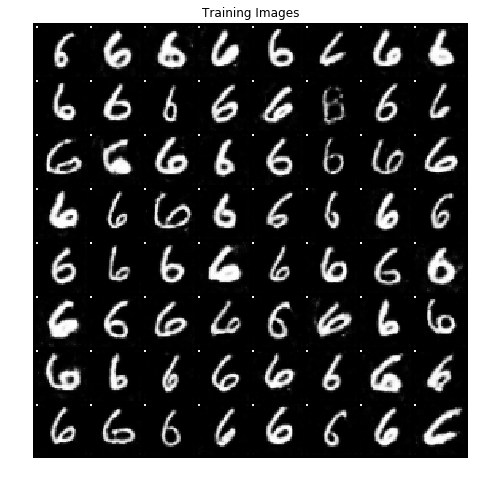

In [2]:

fake_images = torch.load('C:\\Users\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\\saved-fake-images\\WGAN-MaxLogVar0-MinMean0.008-epoch60-fake_Mnist_6-10000-3-32-32.imgs')  
print(fake_images.shape) 

plt.figure(figsize=(8,8))
plt.axis("off") 
plt.title("Training Images") 
# plot first 64 figures
plt.imshow(np.transpose(vutils.make_grid(fake_images.detach()[:64], padding=2, normalize=True).cpu(),(1,2,0)))

#### Create dataset with fake images

In [3]:
from torch.utils.data import Dataset, DataLoader

class Generator(nn.Module):
    def __init__(self,ngf = 32):
        
        super(Generator,self).__init__()
        self.gen=nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d(110, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输入特征图大小. (nc) x 32 x 32
        )
    def forward(self, x):
        x=self.gen(x)
        return x





class FakeNumberDataset(Dataset):
    def __init__(self,fake_number, dataset_name="mnist"):
        """
            mix_ratio: real/fake
        """

        if dataset_name=="mnist":
            odataset = datasets.MNIST('MNIST_data', train=True, transform=transform)
        elif dataset_name=="fashion_mnist":
            odataset = datasets.FashionMNIST('MNIST_data', train=True, transform=transform)
        elif dataset_name=="cifar10":
            odataset = datasets.CIFAR10('MNIST_data', train=True, transform=transform)
        else:
            print("Wrong argument for dataset_name!")
            return None
    


        self.label = []
        self.items = []
        ############################
        n_z=100
        ############################
        #target_num = mix_ratio * fake_images.shape[0]
        #self.added_real = 0 
#         print(len(odataset))
       
        netG = Generator()
        
        with torch.no_grad():
            netG.load_state_dict(torch.load('C:\\Users\\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\\saved-models\\CGAN-Clear-Generator-MaxLogVar48-epoch60-Fashion_MNIST-6\\netG_params.pkl'))
        for idx in range(len(odataset)):
            x_idx, y_idx = odataset[idx]
            print(x_idx)
            if y_idx != fake_number:
                self.items.append(x_idx)
                self.label.append(y_idx)
            #elif y_idx == fake_number and self.added_real < target_num:
            ##############################################
            elif y_idx == 6:
#                 z = Variable(torch.randn(64, n_z, 1, 1))
#                 if self.use_cuda:
#                     z=z.cuda
                
#                 i=i+1
#                 print(i)
                
                noise = torch.randn(1, 100,1,1)
                labels_onehot = np.zeros((1,10))
                labels_onehot[np.arange(1),6]=1 # 这个9换成想生成的数字
                noise=np.concatenate((noise.cpu().numpy(), labels_onehot),axis=1)
                # 每张图片是0到9之间的数字
#                 global labels_onehot
                labels_onehot = Variable(torch.from_numpy(labels_onehot).float())
#                 labels_onehot = Variable(torch.from_numpy(labels_onehot).float()).to(device)
                noise=noise.reshape([-1, 110, 1, 1])
                noise=Variable(torch.from_numpy(noise).float())
#                 print(noise.shape)
                
                fake_image1 = netG(noise)
#                 print(fake_image1.shape)

                fake_image = torch.squeeze(fake_image1,0)
#                 print(fake_image.shape)
                x_idx = fake_image
                
                
                
                
            ##############################################
                self.items.append(x_idx)
                self.label.append(y_idx)
                #self.added_real += 1
                
#         for i in range(fake_images.shape[0]):
#             self.items.append(fake_images[i])
#             self.label.append(fake_number)
            
#         print("Real 6 images in SingleNumberDatasetWithFake:", self.added_real, "Fake images:", fake_images.shape[0])
        
    def checkAddedRealImgs(self):
        return self.added_real
    
    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.items[idx], self.label[idx]

# transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
# trainset = datasets.MNIST('MNIST_data', download=True, train=True, transform=transform)

# train_dataset_with_fake = FakeNumberDataset(fake_images=fake_images[0:6000], mix_ratio=0.01, odataset=trainset)
# trainloader = torch.utils.data.DataLoader(train_dataset_with_fake, batch_size=64, shuffle=True)


# testset = datasets.MNIST('MNIST_data', train=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# print("Number of Train:", len(train_dataset_with_fake), "Number of Test:", len(testset))

### Step 2: create a neural network model (global classifier)

In [4]:
class Model(nn.Module):
    def __init__(self, n_channel=1):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(n_channel, 16, 3), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, stride=1)
        self.conv2 = nn.Sequential(nn.Conv2d(16, 64, 3), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, stride=1)
        self.dropout = nn.Dropout(p=0.5)
        self.lfc1 = nn.Linear(64*26*26, 100)      # 这个4注意改掉
        self.lfc2 = nn.Linear(100, 10)
                                      
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        return self.lfc2(self.lfc1(x))

test_m = Model()
print(test_m)
"""
for param in test_m.parameters():
    print(type(param.data), param.size())

x, y = next(iter(testloader))
print(x.shape)
x = nn.Conv2d(3, 16, 3)(x)
print(x.shape)
x = nn.MaxPool2d(2, stride=1)(x)
print(x.shape)
x = nn.Conv2d(16, 64, 3)(x)
print(x.shape)
x = nn.MaxPool2d(2, stride=1)(x)
print(x.shape)
"""

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (lfc1): Linear(in_features=43264, out_features=100, bias=True)
  (lfc2): Linear(in_features=100, out_features=10, bias=True)
)


'\nfor param in test_m.parameters():\n    print(type(param.data), param.size())\n\nx, y = next(iter(testloader))\nprint(x.shape)\nx = nn.Conv2d(3, 16, 3)(x)\nprint(x.shape)\nx = nn.MaxPool2d(2, stride=1)(x)\nprint(x.shape)\nx = nn.Conv2d(16, 64, 3)(x)\nprint(x.shape)\nx = nn.MaxPool2d(2, stride=1)(x)\nprint(x.shape)\n'

#### helper function to print time elapsed and estimated time remaining given the current time and progress `%`

In [5]:
import time
import math
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    h = math.floor(m / 60)
    m -= h * 60
    return '%dm %ds' % (m, s) if h==0 else '%dh %dm %ds' % (h, m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### Step 3: train data (Adam)

In [7]:
def checktestaccur( m, testdataloader, datasetsize):
    # test 用的是真实数据，包括6
    m.eval()
    all_6 = true_6 = float(0)
    with torch.no_grad():
        
        
        for x, y in testdataloader:
            x = x.to(device)
            y = y.to(device)
            yhat = m(x)
            pre = yhat.argmax(dim=1)
            for i in range(len(y)):
                if y[i].data == 6:
                    all_6 += 1
                    if pre[i].data == 6:
                        true_6 += 1

    return true_6/all_6
        
epoches = 1  # 2 is best, 3 is fine
# change n_channel
print(epoches)
model = Model(n_channel=1).to(device)  
optimizer = torch.optim.Adam(model.parameters()) 
loss_fn = torch.nn.CrossEntropyLoss()
###################################################
transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
# Mnist or FashionMnist
train_dataset_with_fake = FakeNumberDataset(fake_number=6, dataset_name="mnist")
trainloader = torch.utils.data.DataLoader(train_dataset_with_fake, batch_size=64, shuffle=True)
# MNIST or FashionMNIST
testset = datasets.MNIST('MNIST_data', train=False, transform=transform) 
# testset = datasets.CIFAR10('MNIST_data',  train=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True) 
###################################################

losses = [] 
trainaccurs = []
testaccurs = []
epoch_sample = len(train_dataset_with_fake)    #    注意这个base数字
print("number of imgs in train set:", epoch_sample)
start = time.time()
print("Start training loop...")
for epoch in range(1, epoches+1):
    print("-------------------------------------")
    accurate = float(0)
    idx = 0
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        model.train()
        optimizer.zero_grad()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        yhat = yhat.argmax(dim=1)
        accurate += (y==yhat).float().sum()
        idx += 1
        if idx % 300 == 0:
            print(idx, len(trainloader))
        
    losses.append(loss)

    testaccur = checktestaccur(model, testloader, len(testset))    # 注意这里传进去的数字
    testaccurs.append(testaccur)
    trainaccurs.append(accurate/epoch_sample)
    print("[{}\{}], loss: {}, train accuracy: {}, test accuracy: {}.".format(epoch, epoches, loss, accurate/epoch_sample, testaccur))
    print('%s (%d %d%%)' % (timeSince(start, epoch / epoches), epoch, epoch / epoches * 100))
plt.figure()
plt.plot(range(1, len(losses)+1), losses, '-ro')
plt.title("Losses")
# plt.plot(range(len(testaccurs)), testaccurs, '-.go')
# plt.plot(range(len(trainaccurs)), trainaccurs, '--bo')
plt.xlabel('Number of Epochs')
plt.ylabel('Percentage')
# plt.legend(['Loss', 'Test Accur', 'Train Accur'])
plt.show()

1


RuntimeError: Error(s) in loading state_dict for Generator:
	size mismatch for gen.0.weight: copying a param with shape torch.Size([110, 1024, 4, 4]) from checkpoint, the shape in current model is torch.Size([110, 256, 4, 4]).
	size mismatch for gen.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for gen.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for gen.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for gen.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for gen.3.weight: copying a param with shape torch.Size([1024, 512, 4, 4]) from checkpoint, the shape in current model is torch.Size([256, 128, 4, 4]).
	size mismatch for gen.4.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for gen.4.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for gen.4.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for gen.4.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for gen.6.weight: copying a param with shape torch.Size([512, 256, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 64, 4, 4]).
	size mismatch for gen.7.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gen.7.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gen.7.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gen.7.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gen.9.weight: copying a param with shape torch.Size([256, 1, 4, 4]) from checkpoint, the shape in current model is torch.Size([64, 1, 4, 4]).

#### Test global model on real images

In [ ]:
class SingleNumberDataset(Dataset):

    def __init__(self, number=6, dataset="mnist"):
        self.label = number
        self.items = []
        
        transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

        if dataset=="mnist":
            testset = datasets.MNIST('MNIST_data', train=False, transform=transform)
        elif dataset=="fashion_mnist":
            testset = datasets.FashionMNIST('MNIST_data', train=False, transform=transform)
        elif dataset=="cifar10":
            testset = datasets.CIFAR10('MNIST_data', train=False, transform=transform)
        else:
            print("Wrong argument for dataset_name!")
            return None
        
        for idx in range(len(testset)):
            x_idx, y_idx = testset[idx]
            if y_idx == self.label:
                self.items.append(x_idx)
    
    def get_mean(self):
        return torch.stack(self.items, dim=0).mean(dim=0)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.items[idx], self.label

singlenumberdataset = SingleNumberDataset(number=6, dataset="mnist")
snum_trainloader = torch.utils.data.DataLoader(singlenumberdataset, batch_size=64, shuffle=False)

x, y = next(iter(snum_trainloader)) 
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Testing Images")
# plot first 64 figures
plt.imshow(np.transpose(vutils.make_grid(x[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    
print(len(singlenumberdataset))
accur_real_6 = checktestaccur(model, snum_trainloader, len(singlenumberdataset))
print("Testing accuracy:", accur_real_6.item())

### Step X: save model

In [7]:
## Method 1
torch.save(model.state_dict(), "MNIST-Classifier-purefake6train-epoch8-")

# the_model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load("LSTM-Model-nonbd-Epoch17-0330-1927"))

## Method 2
# torch.save(model, "MyBatchModel-Epoch2-GRU-0328-0953")
# the_model = torch.load(PATH)

NameError: name 'model' is not defined